In [1]:
import numpy as np
import pandas as pd
import zipfile
import dask.dataframe as dk
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import mixed_precision
import gc

# Bật mixed precision
mixed_precision.set_global_policy('mixed_float16')
tf.get_logger().setLevel('ERROR')
tf.config.optimizer.set_jit(True)  # Bật XLA để tối ưu hóa

# Cấu hình Dask Client với giới hạn tài nguyên (12GB RAM)
from dask.distributed import Client
client = Client(n_workers=2, threads_per_worker=2, memory_limit='4GB')
print(client)

input_files = [f"file{i+1}" for i in range(3)]
temp_dir = "FL_Data/"
input_files = [temp_dir + output_file for output_file in input_files]
print(input_files)

# Đọc dữ liệu Parquet với Dask, chỉ lấy metadata để giảm tải
df = [dk.read_parquet(file, columns=None) for file in input_files]  # Chỉ đọc metadata
print(df[1].dtypes)

batch_size = 512  # Tăng batch_size để giảm số bước
ratio_test_all = 0.2
features_len = len(df[0].columns) - 1  # Giả định tất cả file có cùng cấu trúc
print("Feature Len:", features_len)

# Ước lượng số lượng mẫu từ metadata thay vì tính chính xác
train_sizes = [df_i.shape[0].compute() * (1 - ratio_test_all) for df_i in df]
val_sizes = [df_i.shape[0].compute() * ratio_test_all * 0.25 for df_i in df]
test_sizes = [df_i.shape[0].compute() * ratio_test_all * 0.75 for df_i in df]

train_dfs = []
val_dfs = []
test_dfs = []
for dff in df:
    train_df, val_test_df = dff.random_split([1 - ratio_test_all, ratio_test_all], shuffle=True)
    test_df, val_df = val_test_df.random_split([0.75, 0.25], shuffle=True)
    train_dfs.append(train_df)
    val_dfs.append(val_df)
    test_dfs.append(test_df)

def dask_to_tf_dataset(dask_df, batch_size, features_len):
    def generator():
        for batch in dask_df.to_delayed():
            batch = batch.compute()
            if batch.empty:
                continue
            X = batch.drop(columns=['label']).values.astype(np.float32)
            y = batch['label'].values.astype(np.int32)
            num_splits = max(1, len(X) // batch_size)
            X_batches = np.array_split(X, num_splits)
            y_batches = np.array_split(y, num_splits)
            for X_batch, y_batch in zip(X_batches, y_batches):
                yield X_batch, y_batch
    output_signature = (
        tf.TensorSpec(shape=(None, features_len), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32),
    )
    dataset = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
    return dataset.cache().prefetch(tf.data.AUTOTUNE).shuffle(buffer_size=1000)

train_gens = [dask_to_tf_dataset(train_df, batch_size, features_len).repeat() for train_df in train_dfs]
val_gens = [dask_to_tf_dataset(val_df, batch_size, features_len).repeat() for val_df in val_dfs]
test_gens = [dask_to_tf_dataset(test_df, batch_size, features_len).repeat() for test_df in test_dfs]

from server_multi import Server
from client_multi import Client
import datetime

num_servers = 1
num_clients = 3

# Ước lượng steps
stepsPerEpoch_Clients = [int(np.ceil(size / batch_size)) for size in train_sizes]
stepsValidate_Clients = [int(np.ceil(size / batch_size)) for size in val_sizes]
stepsTest_Clients = [int(np.ceil(size / batch_size)) for size in test_sizes]

active_servers_list = ['server_' + str(i) for i in range(num_servers)]
active_clients_list = ['client_' + str(i) for i in range(num_clients)]
print(active_servers_list)
print(active_clients_list)

agents_dict = {}
serverObjects = {server_name: Server(server_name=server_name, active_clients_list=active_clients_list)
                 for server_name in active_servers_list}

clientObjects = {client_name: Client(client_name, train_gens[clientID], val_gens[clientID], test_gens[clientID],
                                     stepsPerEpoch_Clients[clientID], stepsValidate_Clients[clientID], stepsTest_Clients[clientID],
                                     active_clients_list=active_clients_list)
                 for clientID, client_name in enumerate(active_clients_list)}

temp_dir_log = clientObjects['client_0'].get_temp_dir()
for index, client_name in enumerate(active_clients_list):
    clientObjects[client_name].get_steps_per_epoch()
    clientObjects[client_name].get_validation_steps()
    clientObjects[client_name].get_test_steps()

agents_dict['server'] = serverObjects
agents_dict['client'] = clientObjects

for agent_name, agent in serverObjects.items():
    agent.set_agentsDict(agents_dict=agents_dict)
for agent_name, agent in clientObjects.items():
    agent.set_agentsDict(agents_dict=agents_dict)

# Giải phóng tài nguyên không cần thiết
del train_dfs, val_dfs, test_dfs, df
gc.collect()

server = agents_dict['server']['server_0']
if __name__ == '__main__':
    server.InitLoop()
    server.final_statistics()
    client.close()  # Đóng Dask Client sau khi hoàn tất

2025-06-24 11:27:54.297912: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-24 11:27:54.307556: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750739274.317394   28004 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750739274.320349   28004 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750739274.329001   28004 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

<Client: 'tcp://127.0.0.1:45621' processes=2 threads=4, memory=7.45 GiB>
['FL_Data/file1', 'FL_Data/file2', 'FL_Data/file3']
flow_duration      float64
Header_Length      float64
Protocol Type      float64
Duration           float64
Rate               float64
Srate              float64
Drate              float64
fin_flag_number    float64
syn_flag_number    float64
rst_flag_number    float64
psh_flag_number    float64
ack_flag_number    float64
ece_flag_number    float64
cwr_flag_number    float64
ack_count          float64
syn_count          float64
fin_count          float64
urg_count          float64
rst_count          float64
HTTP               float64
HTTPS              float64
DNS                float64
Telnet             float64
SMTP               float64
SSH                float64
IRC                float64
TCP                float64
UDP                float64
DHCP               float64
ARP                float64
ICMP               float64
IPv                float64
LLC        

I0000 00:00:1750739279.633814   28004 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


['server_0']
['client_0', 'client_1', 'client_2']
Train steps: 5338
Val steps: 334
Test steps: 1001
Train steps: 3739
Val steps: 234
Test steps: 702
Train steps: 4262
Val steps: 267
Test steps: 800
====================================== Đang chạy Iteration 1 ======================================
Epoch 1/5
Epoch 1/5
Epoch 1/5


I0000 00:00:1750739283.108033   28107 service.cc:152] XLA service 0x7f024c003ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750739283.108069   28107 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
I0000 00:00:1750739283.122088   28107 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750739283.256392   28102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-06-24 11:28:07.396383: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


4432/5338 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9065 - loss: 0.2621

2025-06-24 11:28:39.556738: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads



4473/5338 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9068 - loss: 0.2613

2025-06-24 11:28:39.797996: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads



4525/5338 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9071 - loss: 0.2602

2025-06-24 11:28:40.188919: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads



4825/5338 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9090 - loss: 0.2545

2025-06-24 11:28:41.744595: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads

2025-06-24 11:28:41.781285: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 11:28:41.800674: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads



5096/5338 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9105 - loss: 0.2497

2025-06-24 11:28:42.993466: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 11:28:43.005146: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads



5304/5338 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9116 - loss: 0.2464

2025-06-24 11:28:44.127000: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 11:28:44.154001: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads

2025-06-24 11:28:44.267328: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads

2025-06-24 11:28:44.337843: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads

2025-06-24 11:28:44.473499: E external

5307/5338 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9116 - loss: 0.2463

2025-06-24 11:28:44.594228: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-24 11:28:44.681305: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-24 11:28:44.763516: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


5308/5338 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9116 - loss: 0.2463

2025-06-24 11:28:44.844415: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-24 11:28:44.934986: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-24 11:28:45.021227: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


5309/5338 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9116 - loss: 0.2463

2025-06-24 11:28:45.102662: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-24 11:28:45.186011: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


5317/5338 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9116 - loss: 0.2462

2025-06-24 11:28:45.364305: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-24 11:28:45.520219: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


5335/5338 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9117 - loss: 0.2459

2025-06-24 11:28:46.347956: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads

2025-06-24 11:28:46.617323: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 11:28:46.830597: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads

2025-06-24 11:28:47.085377: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 11:28:47.439012: I external

3739/3739 ━━━━━━━━━━━━━━━━━━━━ 83s 20ms/step - accuracy: 0.8878 - loss: 0.3163 - val_accuracy: 0.9455 - val_loss: 0.1331
Epoch 2/5
4262/4262 ━━━━━━━━━━━━━━━━━━━━ 83s 17ms/step - accuracy: 0.9078 - loss: 0.2624 - val_accuracy: 0.9513 - val_loss: 0.1205
Epoch 2/5
 254/3739 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.9475 - loss: 0.1343

2025-06-24 11:29:24.199925: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 72 bytes spill stores, 72 bytes spill loads

2025-06-24 11:29:24.348517: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 384 bytes spill stores, 384 bytes spill loads



 292/3739 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.9475 - loss: 0.1341

2025-06-24 11:29:24.472768: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 808 bytes spill stores, 716 bytes spill loads



 336/3739 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9476 - loss: 0.1339

2025-06-24 11:29:24.969537: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


5338/5338 ━━━━━━━━━━━━━━━━━━━━ 87s 15ms/step - accuracy: 0.9117 - loss: 0.2458 - val_accuracy: 0.9506 - val_loss: 0.1218
Epoch 2/5
3739/3739 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.9483 - loss: 0.1310 - val_accuracy: 0.9524 - val_loss: 0.1162
Epoch 3/5
4262/4262 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9495 - loss: 0.1277 - val_accuracy: 0.9530 - val_loss: 0.1138
Epoch 3/5
5338/5338 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.9504 - loss: 0.1247 - val_accuracy: 0.9524 - val_loss: 0.1145
2253/4262 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9519 - loss: 0.1206Epoch 3/5
3739/3739 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9513 - loss: 0.1219 - val_accuracy: 0.9545 - val_loss: 0.1118
Epoch 4/5
4262/4262 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9521 - loss: 0.1199 - val_accuracy: 0.9545 - val_loss: 0.1095
Epoch 4/5
3739/3739 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.9529 - loss: 0.1175 - val_accuracy: 0.9559 - val_loss: 0.1081
Epoch 5/5
5338/5338 ━━━

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3066/5338 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9541 - loss: 0.1131client_1 End Produce Weights
4262/4262 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9547 - loss: 0.1118 - val_accuracy: 0.9559 - val_loss: 0.1057
Done model fit

client_2 End Produce Weights
5338/5338 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.9543 - loss: 0.1127 - val_accuracy: 0.9552 - val_loss: 0.1074
Epoch 5/5
5338/5338 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9551 - loss: 0.1104 - val_accuracy: 0.9574 - val_loss: 0.1031
Done model fit

client_0 End Produce Weights
Đã lưu global model cho iteration 1 tại multiclass_FL_log/Month06-Day24-11h-28p/client_1_log/global_model_iter_1.keras
Đã lưu global model cho iteration 1 tại multiclass_FL_log/Month06-Day24-11h-28p/client_2_log/global_model_iter_1.keras
Đã lưu global model cho iteration 1 tại multiclass_FL_log/Month06-Day24-11h-27p/client_0_log/global_model_iter_1.keras
  3/702 ━━━━━━━━━━━━━━━━━━━━ 4:49 414ms/step - accuracy: 0.9647 - loss: 0.099

2025-06-24 11:31:08.214423: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 724 bytes spill stores, 788 bytes spill loads

2025-06-24 11:31:08.296262: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 292 bytes spill stores, 292 bytes spill loads

2025-06-24 11:31:08.388885: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 52 bytes spill stores, 52 bytes spill loads



   1/1001 ━━━━━━━━━━━━━━━━━━━━ 1:36:34 6s/step - accuracy: 0.9501 - loss: 0.1068

2025-06-24 11:31:08.712833: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 8 bytes spill stores, 8 bytes spill loads



 24/702 ━━━━━━━━━━━━━━━━━━━━ 1:36 142ms/step - accuracy: 0.9544 - loss: 0.1128

2025-06-24 11:31:10.078722: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 72 bytes spill stores, 72 bytes spill loads



  5/800 ━━━━━━━━━━━━━━━━━━━━ 10:15 775ms/step - accuracy: 0.9567 - loss: 0.0955

2025-06-24 11:31:10.297665: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 11:31:10.408887: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 808 bytes spill stores, 716 bytes spill loads

2025-06-24 11:31:10.891774: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 11:31:11.069355: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads



  8/800 ━━━━━━━━━━━━━━━━━━━━ 7:34 574ms/step - accuracy: 0.9568 - loss: 0.0964 

2025-06-24 11:31:11.391090: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads

2025-06-24 11:31:11.530017: W external/local_xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1369] AutotunerUtil::AddResult already existed: <key model='CUDA: 8.9, Cores: 20, GPU clock: 2.055 GHz, Memory bandwidth: 192 GB/s, L2 cache: 24 MB', hlo='{
  tmp_0 = f16[513,128]{1,0} parameter(0)
  tmp_1 = f32[128,5]{1,0} parameter(1)
  tmp_2 = f16[128,5]{1,0} convert(f32[128,5]{1,0} tmp_1)
  ROOT tmp_3 = f16[513,5]{1,0} dot(f16[513,128]{1,0} tmp_0, f16[128,5]{1,0} tmp_2), lhs_contracting_dims={1}, rhs_contracting_dims={0}, frontend_attributes={grad_x="false",grad_y="false"}
}'>
2025-06-24 11:31:11.553632: W external/local_xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1369] AutotunerUtil::AddResult already existed: <key model='CUDA: 8.9, 

702/702 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9551 - loss: 0.1094
800/800 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.9571 - loss: 0.1034
702/702 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5749 - loss: 1.1512
Arguments:  Performance Metrics for client_1 on iteration 1 
------------------------------------------- 
local accuracy: 0.9553335309028625 
local loss: 0.1088593527674675 
global accuracy: 0.5750109553337097 
global_loss: 1.1513081789016724 
local compute time: 0:02:37.208863 
Simulated time to receive global weights: 0:03:02.225603 
 

800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7455 - loss: 0.8668
Arguments:  Performance Metrics for client_2 on iteration 1 
------------------------------------------- 
local accuracy: 0.95704185962677 
local loss: 0.10388857126235962 
global accuracy: 0.745661735534668 
global_loss: 0.8665159940719604 
local compute time: 0:02:45.544094 
Simulated time to receive global weights: 0:03:02.225603 
 

1001/1001 ━━━━━━

In [3]:
from tensorflow.keras.models import load_model

#tempdirs = [f"federated_learning_log/Month05-Day27-18h-56p/client_{i}_log/" for i in range(len(active_clients_list))]
tempdirs = [temp_dir_log + f"/client_{i}_log/" for i in range(len(active_clients_list))]

model_names =[f"global_model_iter_{i+1}.keras" for i in range(5)]
print(model_names)
models = {}

for i, client_name in enumerate(active_clients_list):
    models[client_name] = [load_model(tempdirs[i]+model_name) for model_name in model_names]
print (models['client_0'])


['global_model_iter_1.keras', 'global_model_iter_2.keras', 'global_model_iter_3.keras', 'global_model_iter_4.keras', 'global_model_iter_5.keras']
[<Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>]


2025-06-24 11:43:34.608856: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


519463
<Sequential name=sequential, built=True>
16226/16234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2025-06-24 11:43:53.241261: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 128 bytes spill stores, 128 bytes spill loads

2025-06-24 11:43:53.309141: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 384 bytes spill stores, 384 bytes spill loads



16234/16234 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step
<Sequential name=sequential, built=True>
16234/16234 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
<Sequential name=sequential, built=True>
16234/16234 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
<Sequential name=sequential, built=True>
16234/16234 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
<Sequential name=sequential, built=True>
16234/16234 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
Precision Score:  [0.28837067196418065, 0.8921024724632348, 0.9063669830656401, 0.9039836067001591, 0.9065479702399021]
Recall Score:  [0.2301375910121941, 0.8397324677538242, 0.837832501109222, 0.8461453138908208, 0.8474942092162502]
F1 Score:  [0.17863672050950224, 0.8589675321942822, 0.8613447692950779, 0.8670560033956903, 0.8688792074202143]


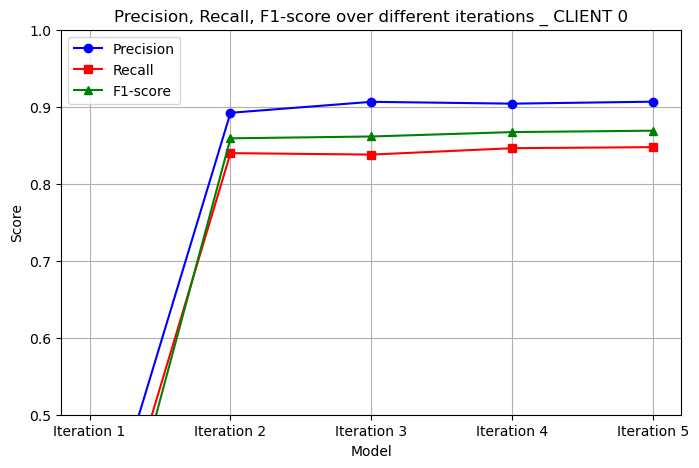

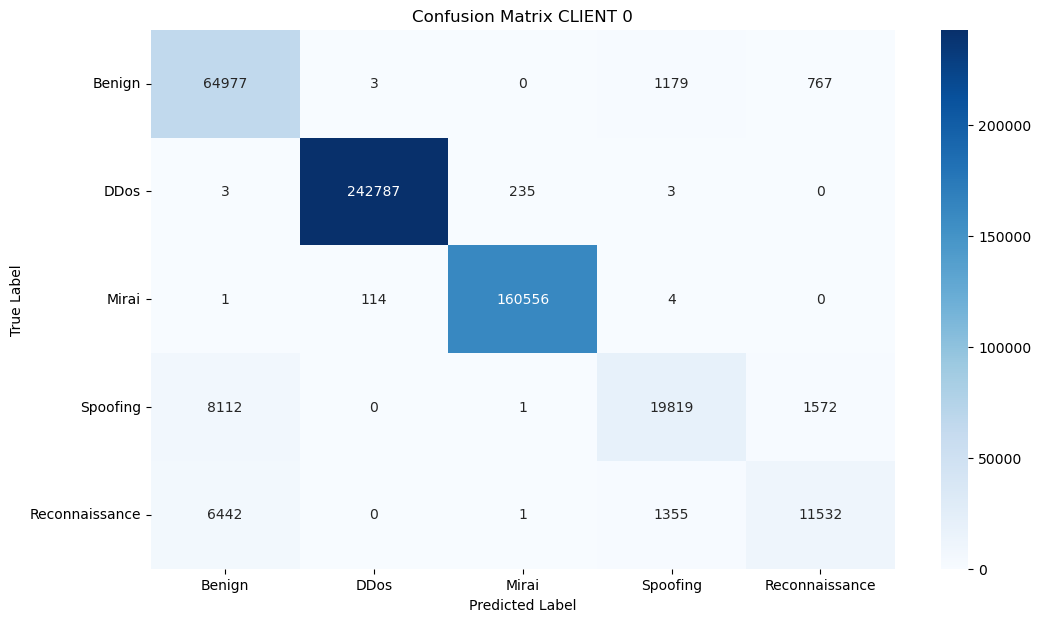

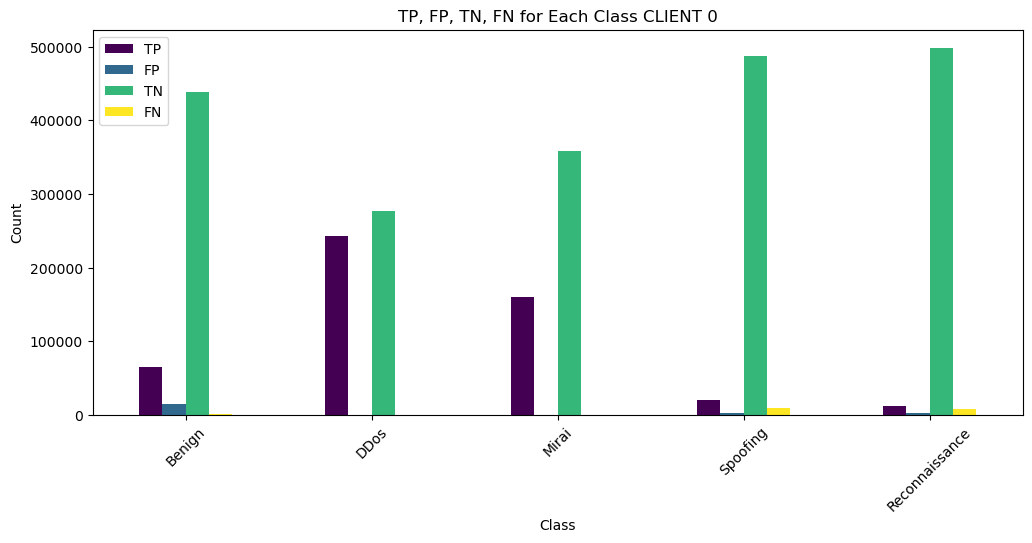

In [5]:
# Client 0
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
precisions = []
recalls = []
f1s = []

Iterations = [f"Iteration {index+1}" for index in range(5)]

X_test = []
y_test = []
for X_batch, y_batch in test_gens[0].take(stepsTest_Clients[0]):
    X_test.append(X_batch.numpy())
    y_test.append(y_batch.numpy())
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print(len(X_test))
for iteration in range(len(Iterations)):
    print(models['client_0'][iteration])
    y_pred_pre = models['client_0'][iteration].predict(X_test, verbose=1)
    y_pred = np.argmax(y_pred_pre, axis=1)
    
    precisions.append(precision_score(y_test, y_pred, average='macro'))
    recalls.append(recall_score(y_test, y_pred, average='macro'))
    f1s.append(f1_score(y_test, y_pred, average='macro'))
print("Precision Score: ", precisions)
print("Recall Score: ", recalls)
print("F1 Score: ", f1s)  


# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(Iterations, precisions, marker='o', linestyle='-', label="Precision", color='blue')
plt.plot(Iterations, recalls, marker='s', linestyle='-', label="Recall", color='red')
plt.plot(Iterations, f1s, marker='^', linestyle='-', label="F1-score", color='green')

# Thêm tiêu đề và nhãn
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score over different iterations _ CLIENT 0")
plt.legend()
plt.ylim(0.5, 1)  # Giới hạn từ 0 đến 1
plt.grid(True)

# Hiển thị đồ thị
plt.show()


attack_types =['Benign', 'DDos', 'Mirai', 'Spoofing', 'Reconnaissance']
cm = confusion_matrix(y_test, y_pred)
    # Vẽ heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
plt.yticks(rotation=360)
# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CLIENT 0")

# Hiển thị
plt.show()

metrics = []


num_classes = len(attack_types)

# Duyệt từng lớp để tính TP, FP, TN, FN
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])

# Vẽ biểu đồ
df_metrics.set_index("Attack_Types").plot(kind="bar", figsize=(12, 5), colormap="viridis")

# Thêm nhãn
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("TP, FP, TN, FN for Each Class CLIENT 0")
plt.xticks(rotation=45)
plt.legend(["TP", "FP", "TN", "FN"])

# Hiển thị
plt.show()

363644
<Sequential name=sequential_1, built=True>
11362/11364 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2025-06-24 11:45:54.721871: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_103', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 11:45:54.778189: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_103', 12 bytes spill stores, 12 bytes spill loads

2025-06-24 11:45:54.868728: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_103', 16 bytes spill stores, 16 bytes spill loads

2025-06-24 11:45:54.912625: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_103', 272 bytes spill stores, 272 bytes spill loads



11364/11364 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
<Sequential name=sequential_1, built=True>
11364/11364 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
<Sequential name=sequential_1, built=True>
11364/11364 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
<Sequential name=sequential_1, built=True>
11364/11364 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
<Sequential name=sequential_1, built=True>
11364/11364 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
Precision Score:  [0.4359396439047617, 0.8909504459101825, 0.8904619127352292, 0.8969454615795979, 0.8964579882971581]
Recall Score:  [0.39776790463310435, 0.8368438194173013, 0.851612682249173, 0.8526045610904903, 0.8542433380220411]
F1 Score:  [0.2998295501242005, 0.8559166804506291, 0.8663049879769694, 0.8692864043650127, 0.8707823195717641]


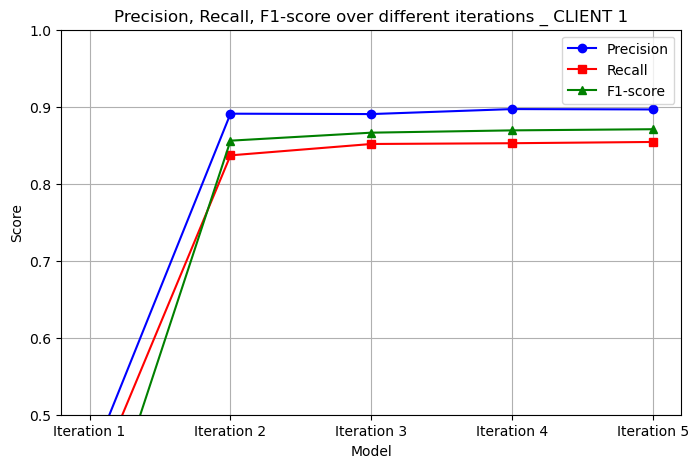

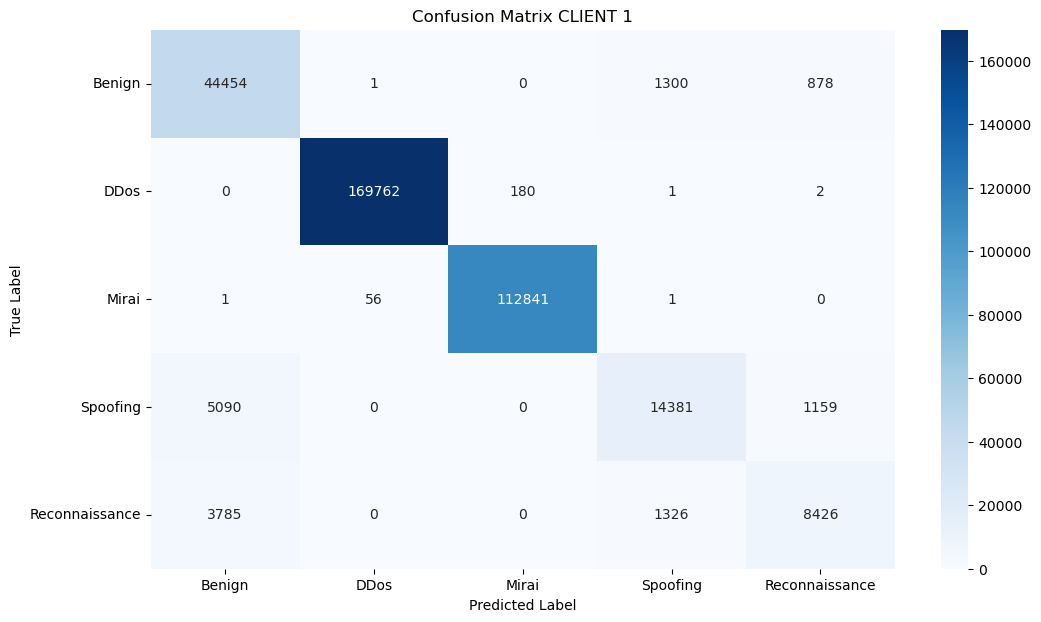

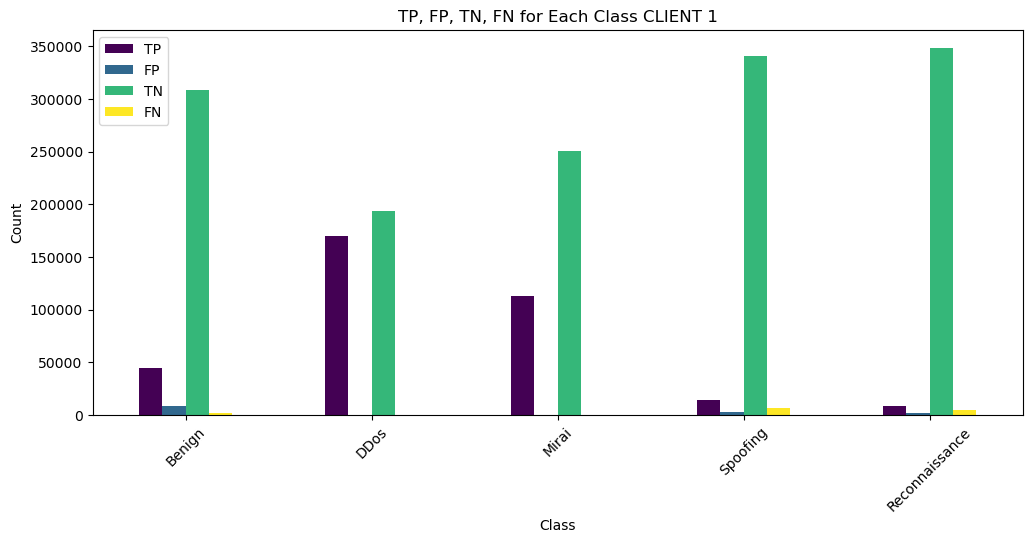

In [6]:
#Client 1

precisions = []
recalls = []
f1s = []

Iterations = [f"Iteration {index+1}" for index in range(5)]

X_test = []
y_test = []
for X_batch, y_batch in test_gens[1].take(stepsTest_Clients[1]):
    X_test.append(X_batch.numpy())
    y_test.append(y_batch.numpy())
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print(len(X_test))
for iteration in range(len(Iterations)):
    print(models['client_1'][iteration])
    y_pred_pre = models['client_1'][iteration].predict(X_test, verbose=1)
    y_pred = np.argmax(y_pred_pre, axis=1)
    
    precisions.append(precision_score(y_test, y_pred, average='macro'))
    recalls.append(recall_score(y_test, y_pred, average='macro'))
    f1s.append(f1_score(y_test, y_pred, average='macro'))
print("Precision Score: ", precisions)
print("Recall Score: ", recalls)
print("F1 Score: ", f1s)  


# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(Iterations, precisions, marker='o', linestyle='-', label="Precision", color='blue')
plt.plot(Iterations, recalls, marker='s', linestyle='-', label="Recall", color='red')
plt.plot(Iterations, f1s, marker='^', linestyle='-', label="F1-score", color='green')

# Thêm tiêu đề và nhãn
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score over different iterations _ CLIENT 1")
plt.legend()
plt.ylim(0.5, 1)  # Giới hạn từ 0 đến 1
plt.grid(True)

# Hiển thị đồ thị
plt.show()


attack_types =['Benign', 'DDos', 'Mirai', 'Spoofing', 'Reconnaissance']
cm = confusion_matrix(y_test, y_pred)
    # Vẽ heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
plt.yticks(rotation=360)
# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CLIENT 1")

# Hiển thị
plt.show()


metrics = []

# Số lượng lớp (10 lớp)
num_classes = len(attack_types)

# Duyệt từng lớp để tính TP, FP, TN, FN
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])

# Vẽ biểu đồ
df_metrics.set_index("Attack_Types").plot(kind="bar", figsize=(12, 5), colormap="viridis")

# Thêm nhãn
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("TP, FP, TN, FN for Each Class CLIENT 1")
plt.xticks(rotation=45)
plt.legend(["TP", "FP", "TN", "FN"])

# Hiển thị
plt.show()

2025-06-24 11:48:13.222329: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


413814
<Sequential name=sequential_2, built=True>
12931/12932 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2025-06-24 11:48:28.332620: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_103', 12 bytes spill stores, 12 bytes spill loads

2025-06-24 11:48:28.407503: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_103', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 11:48:28.585212: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_103', 16 bytes spill stores, 16 bytes spill loads

2025-06-24 11:48:28.772415: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_103', 272 bytes spill stores, 272 bytes spill loads



12932/12932 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step
<Sequential name=sequential_2, built=True>
12932/12932 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
<Sequential name=sequential_2, built=True>
12932/12932 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
<Sequential name=sequential_2, built=True>
12932/12932 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
<Sequential name=sequential_2, built=True>
12932/12932 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
Precision Score:  [0.6184969651049482, 0.8942507109589505, 0.9006125417339502, 0.90017408985542, 0.9056264428792076]
Recall Score:  [0.38445391909379195, 0.8388368427936357, 0.8428613361318072, 0.8554726746839201, 0.8499172833103119]
F1 Score:  [0.3465277618007655, 0.8590325469921346, 0.8638044700781758, 0.8728270679460579, 0.8705520761309276]


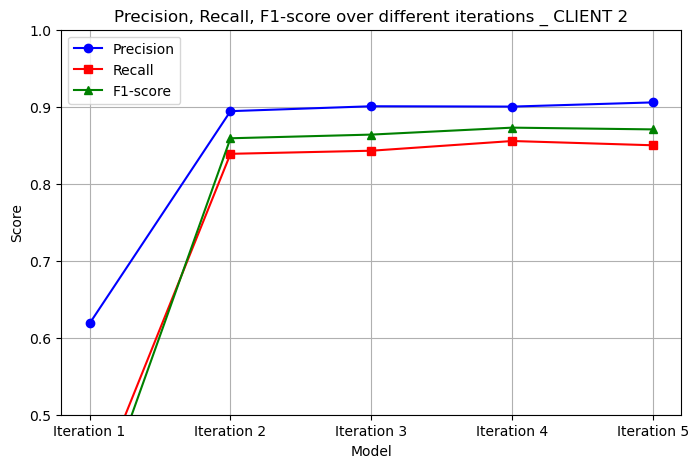

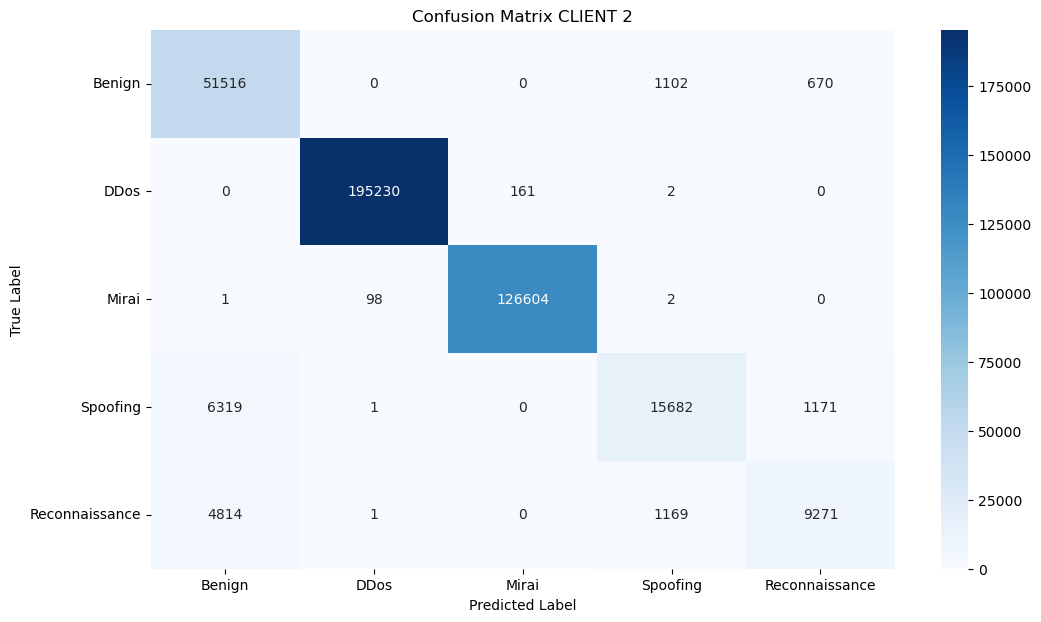

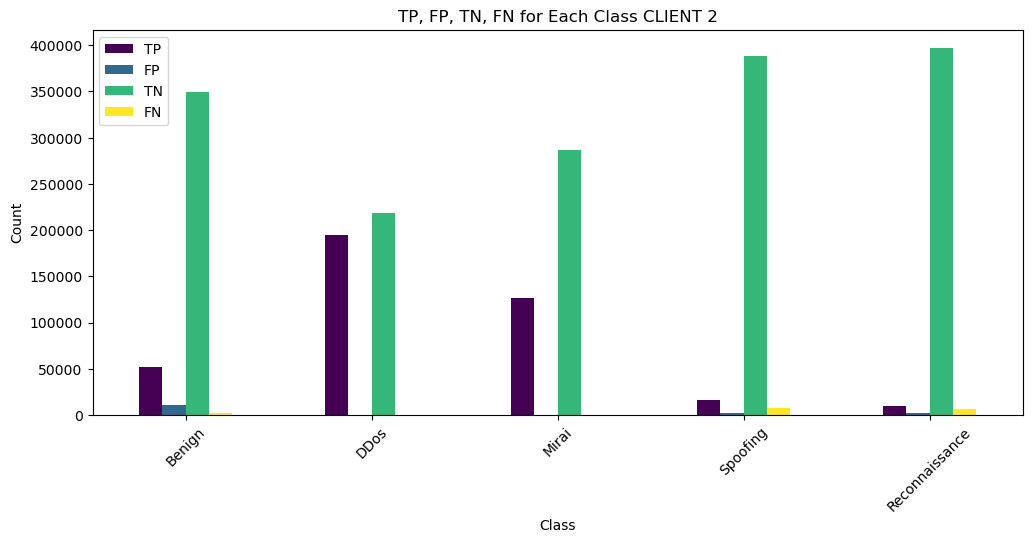

In [7]:
#Client 2

precisions = []
recalls = []
f1s = []

Iterations = [f"Iteration {index+1}" for index in range(5)]

X_test = []
y_test = []
for X_batch, y_batch in test_gens[2].take(stepsTest_Clients[2]):
    X_test.append(X_batch.numpy())
    y_test.append(y_batch.numpy())
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print(len(X_test))
for iteration in range(len(Iterations)):
    print(models['client_2'][iteration])
    y_pred_pre = models['client_2'][iteration].predict(X_test, verbose=1)
    y_pred = np.argmax(y_pred_pre, axis=1)
    
    precisions.append(precision_score(y_test, y_pred, average='macro'))
    recalls.append(recall_score(y_test, y_pred, average='macro'))
    f1s.append(f1_score(y_test, y_pred, average='macro'))
print("Precision Score: ", precisions)
print("Recall Score: ", recalls)
print("F1 Score: ", f1s)  


# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(Iterations, precisions, marker='o', linestyle='-', label="Precision", color='blue')
plt.plot(Iterations, recalls, marker='s', linestyle='-', label="Recall", color='red')
plt.plot(Iterations, f1s, marker='^', linestyle='-', label="F1-score", color='green')

# Thêm tiêu đề và nhãn
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score over different iterations _ CLIENT 2")
plt.legend()
plt.ylim(0.5, 1)  # Giới hạn từ 0 đến 1
plt.grid(True)

# Hiển thị đồ thị
plt.show()


attack_types =['Benign', 'DDos', 'Mirai', 'Spoofing', 'Reconnaissance']
cm = confusion_matrix(y_test, y_pred)
    # Vẽ heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
plt.yticks(rotation=360)
# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CLIENT 2")

# Hiển thị
plt.show()


metrics = []

# Số lượng lớp (10 lớp)
num_classes = len(attack_types)

# Duyệt từng lớp để tính TP, FP, TN, FN
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])

# Vẽ biểu đồ
df_metrics.set_index("Attack_Types").plot(kind="bar", figsize=(12, 5), colormap="viridis")

# Thêm nhãn
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("TP, FP, TN, FN for Each Class CLIENT 2")
plt.xticks(rotation=45)
plt.legend(["TP", "FP", "TN", "FN"])

# Hiển thị
plt.show()

['Iteration_1.csv', 'Iteration_2.csv', 'Iteration_3.csv', 'Iteration_4.csv', 'Iteration_5.csv']


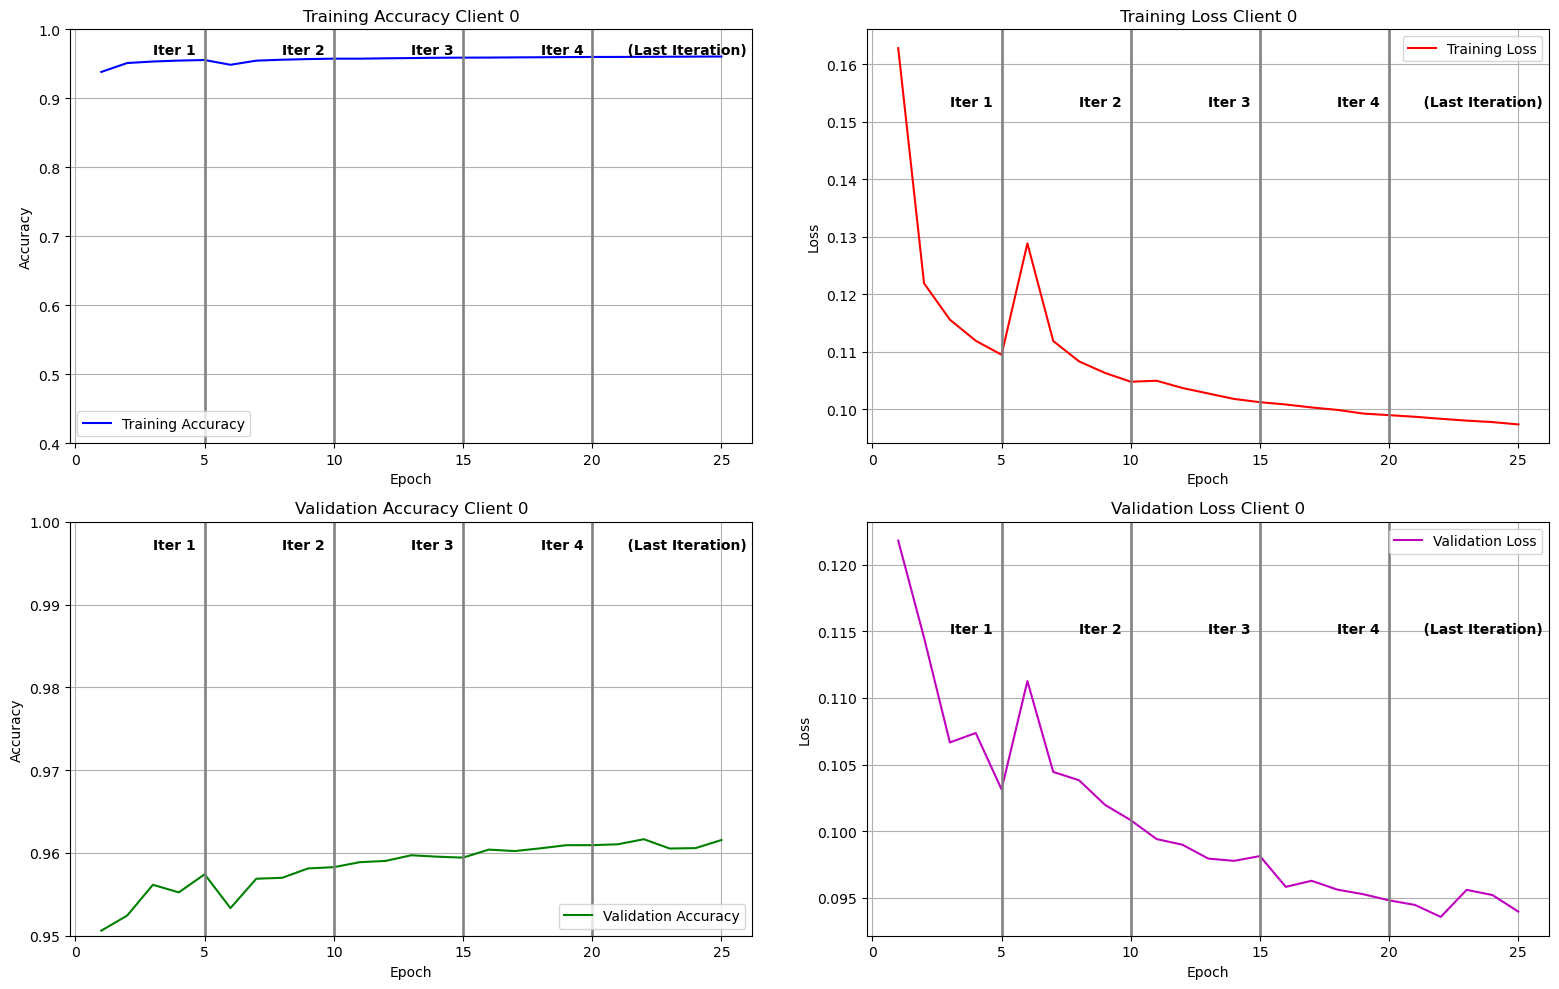

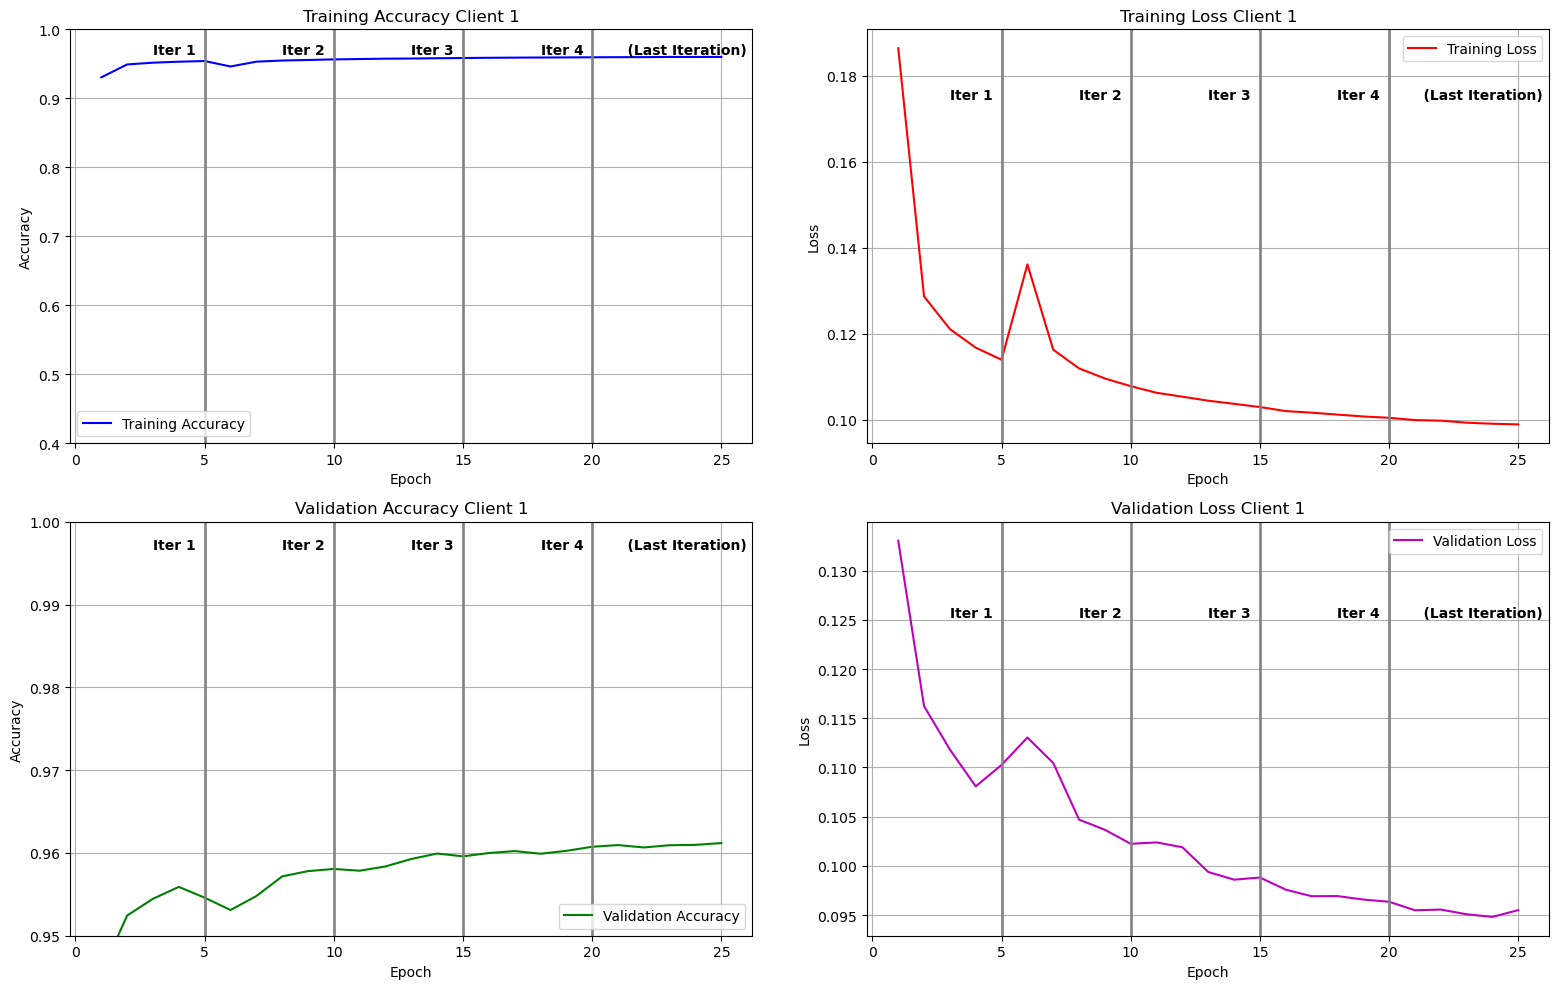

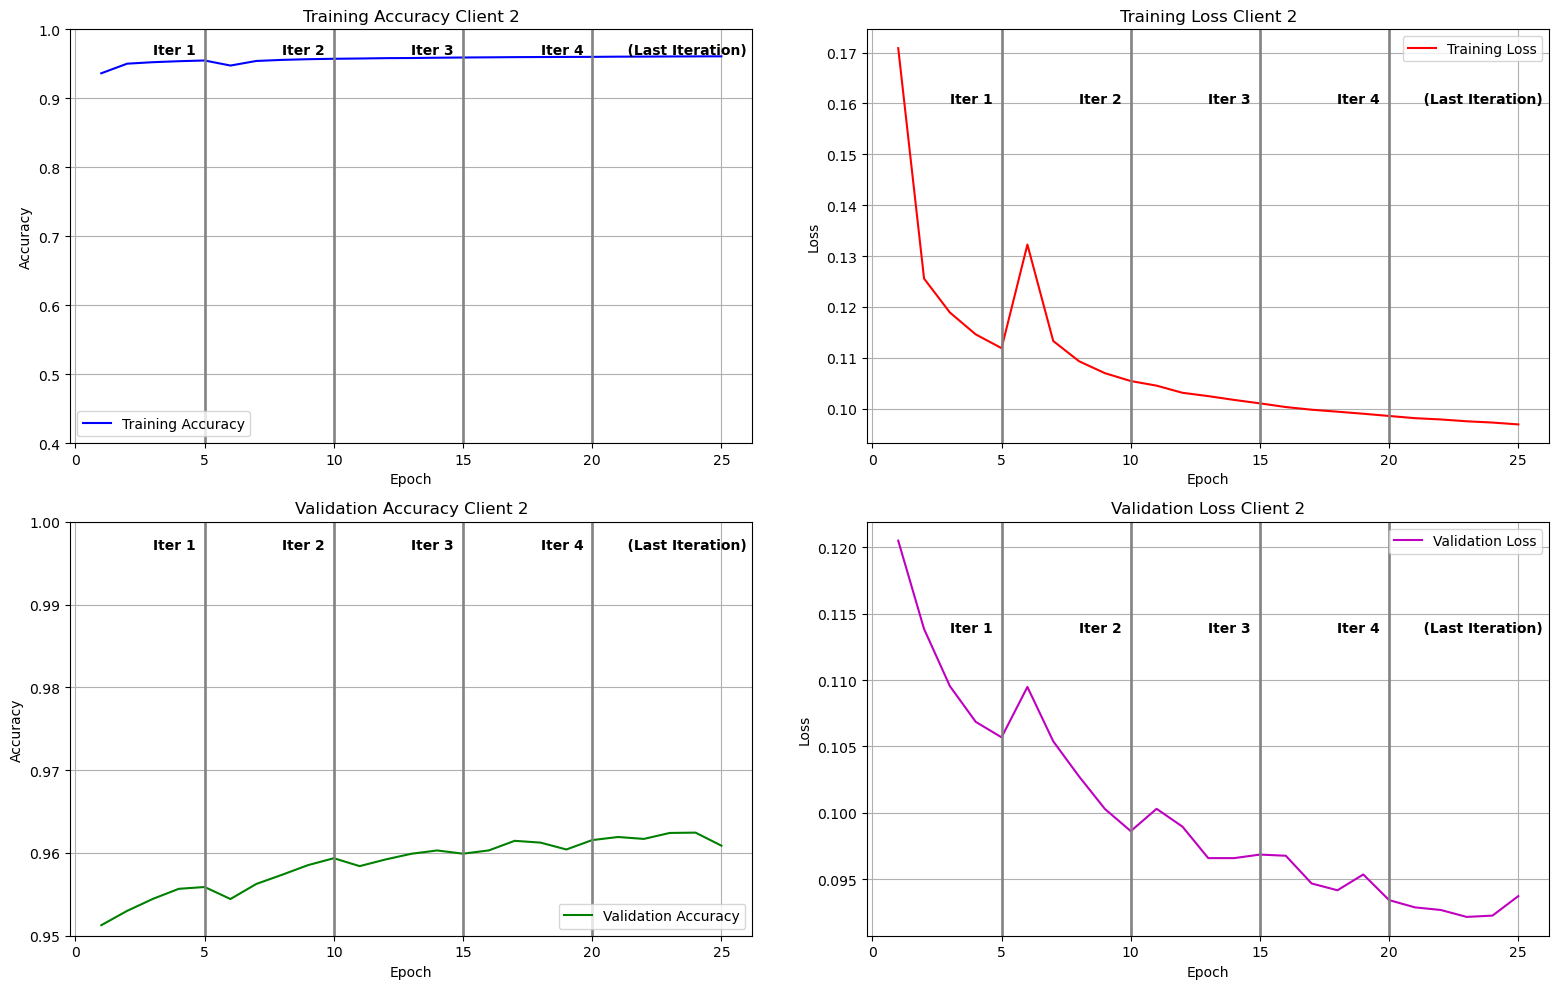

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Giả định tempdirs đã được định nghĩa
# Ví dụ: tempdirs = [f"federated_learning_log/21h-04p-Month05-Day27/client_{i}_log/" for i in range(4)]
#tempdirs = [f"federated_learning_log/Month05-Day27-18h-56p/client_{i}_log/" for i in range(4)]  # 4 clients
log_names = [f"Iteration_{i+1}.csv" for i in range(5)]
print(log_names)

# Vẽ biểu đồ cho từng client
for i in range(3):
    # Kết hợp dữ liệu từ các file log
    all_logs = []
    for log_name in log_names:
        file_path = tempdirs[i] + log_name
        if not os.path.exists(file_path):
            print(f"File {file_path} không tồn tại!")
            continue
        log_part = pd.read_csv(file_path)
        all_logs.append(log_part)

    # Kết hợp dữ liệu từ các file log
    log_df = pd.concat(all_logs, ignore_index=True)
    epochs = range(1, len(log_df) + 1)  # Tổng cộng 20 epoch (4 iterations x 5 epochs)

    plt.figure(figsize=(16, 10))

    # Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs, log_df['accuracy'], 'b-', label='Training Accuracy')
    # Thêm đường kẻ dọc tại epoch 5, 10, 15
    for iter_idx in range(1, len(log_names)):
        plt.axvline(x=iter_idx * 5, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        if iter_idx < len(log_names) - 1:  
            plt.text(iter_idx * 5 - 2, 0.98, f'Iter {iter_idx}', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
        else:  # Iter 4
            plt.text(iter_idx * 5 - 2, 0.98, f'Iter {iter_idx}         (Last Iteration)', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
    plt.title(f'Training Accuracy Client {i}')
    plt.title(f'Training Accuracy Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.ylim(0.40, 1.0)

    # Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, log_df['loss'], 'r-', label='Training Loss')
    for iter_idx in range(1, len(log_names)):
        plt.axvline(x=iter_idx * 5, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        if iter_idx < len(log_names) - 1:
            plt.text(iter_idx * 5 - 2, max(log_df['loss']) * 0.95, f'Iter {iter_idx}', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
        else:
            plt.text(iter_idx * 5 - 2, max(log_df['loss']) * 0.95, f'Iter {iter_idx}         (Last Iteration)', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
    plt.title(f'Training Loss Client {i}')
    plt.title(f'Training Loss Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Validation Accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, log_df['val_accuracy'], 'g-', label='Validation Accuracy')
    for iter_idx in range(1, len(log_names)):
        plt.axvline(x=iter_idx * 5, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        if iter_idx < len(log_names) - 1:
            plt.text(iter_idx * 5 - 2, 0.998, f'Iter {iter_idx}', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
        else:
            plt.text(iter_idx * 5 - 2, 0.998, f'Iter {iter_idx}         (Last Iteration)', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
    plt.title(f'Validation Accuracy Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.ylim(0.95, 1.0)

    # Validation Loss
    plt.subplot(2, 2, 4)
    plt.plot(epochs, log_df['val_loss'], 'm-', label='Validation Loss')
    for iter_idx in range(1, len(log_names)):
        plt.axvline(x=iter_idx * 5, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        if iter_idx < len(log_names) - 1:
            plt.text(iter_idx * 5 - 2, max(log_df['val_loss']) * 0.95, f'Iter {iter_idx}', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
        else:
            plt.text(iter_idx * 5 - 2, max(log_df['val_loss']) * 0.95, f'Iter {iter_idx}         (Last Iteration)', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
    plt.title(f'Validation Loss Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

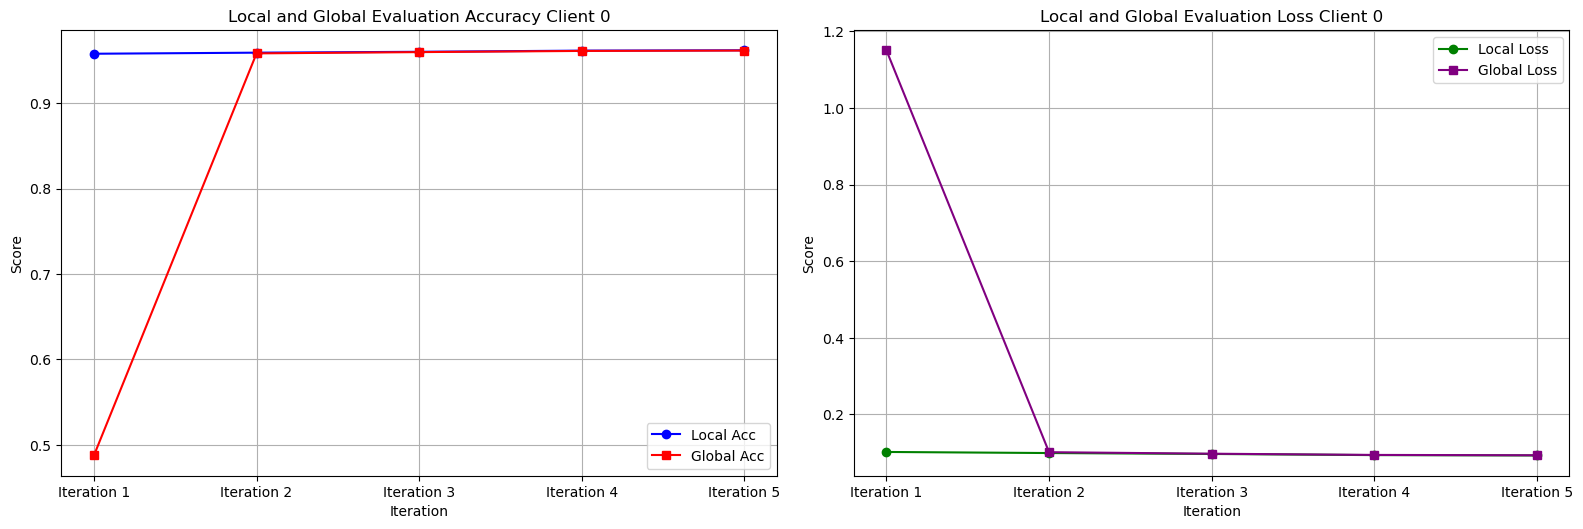

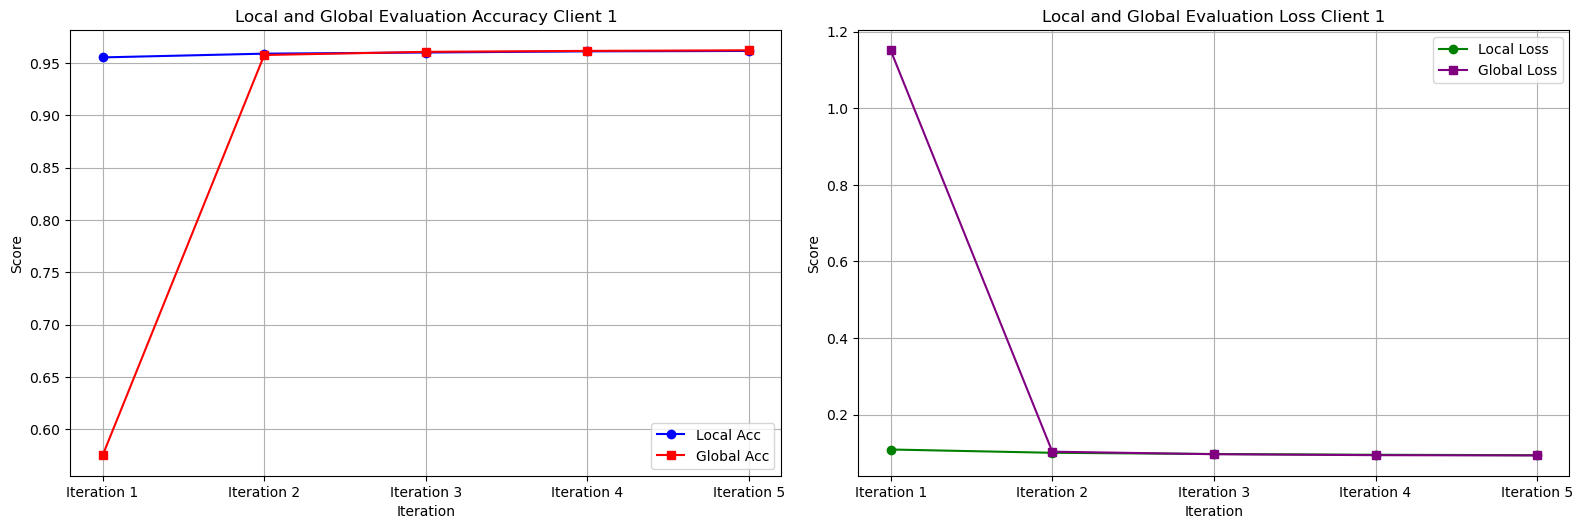

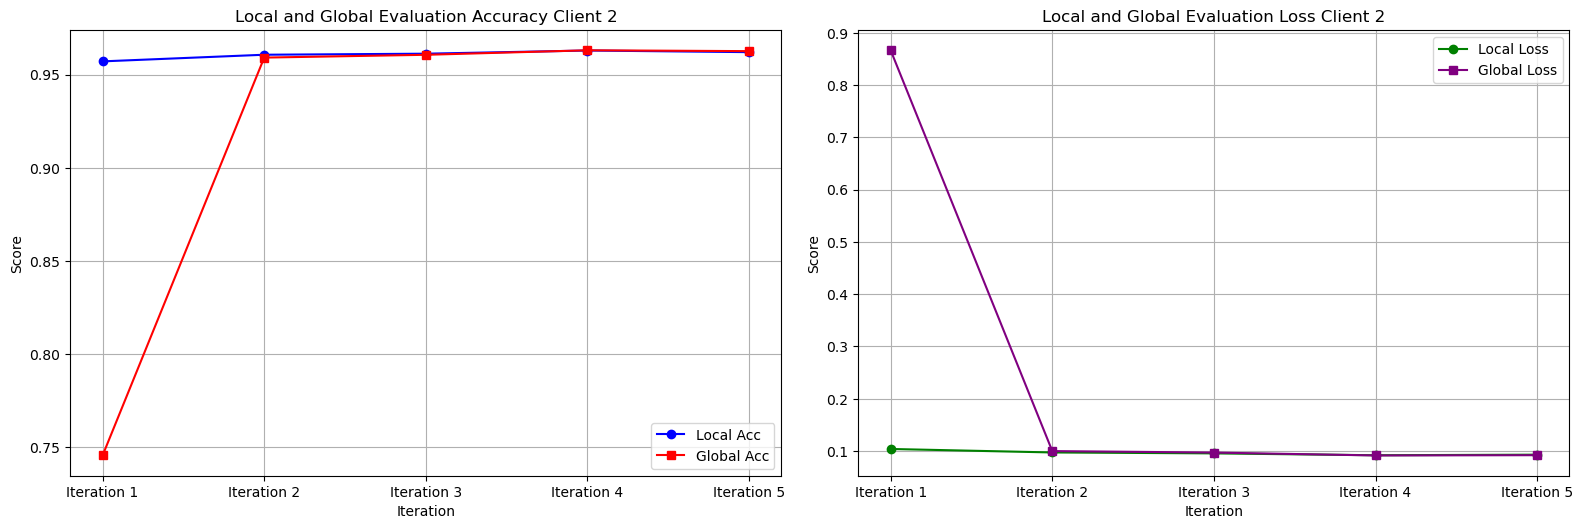

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Giả định tempdirs đã được định nghĩa
# Ví dụ: tempdirs = [f"federated_learning_log/21h-04p-Month05-Day27/client_{i}_log/" for i in range(4)]
#tempdirs = [f"federated_learning_log/Month05-Day27-18h-56p/client_{i}_log/" for i in range(4)]  # 4 clients
Iterations = [f"Iteration {index+1}" for index in range(5)]

# Vẽ biểu đồ cho từng client
for i in range(3):
    file_path_local = tempdirs[i] + "local_val.csv"
    file_path_global = tempdirs[i] + "global_val.csv"
  
    local_val = pd.read_csv(file_path_local)
    global_val = pd.read_csv(file_path_global)
    # Vẽ biểu đồ
    plt.figure(figsize=(16, 10))
    plt.subplot(2, 2, 1)
    plt.plot(Iterations, local_val['local_acc'], marker='o', linestyle='-', label="Local Acc", color='blue')
    plt.plot(Iterations, global_val['global_acc'], marker='s', linestyle='-', label="Global Acc", color='red')
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(f"Local and Global Evaluation Accuracy Client {i}")
    plt.legend()
    #plt.ylim(0.5, 1)  # Giới hạn từ 0 đến 1
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(Iterations, local_val['local_loss'], marker='o', linestyle='-', label="Local Loss", color='green')
    plt.plot(Iterations, global_val['global_loss'], marker='s', linestyle='-', label="Global Loss", color='purple')
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(f"Local and Global Evaluation Loss Client {i}")
    plt.legend()
    #plt.ylim(0.5, 1)  # Giới hạn từ 0 đến 1
    plt.grid(True)

    plt.tight_layout()
    # Hiển thị đồ thị
    plt.show()